## Initial Setup

In [1]:
#import necessary libraries
import nltk
import string
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.tokenize import word_tokenize

In [ ]:
!python -m spacy download en_core_web_md
nltk.download('punkt')

In [3]:
# Read the text file into a DataFrame
df = pd.read_csv('/content/DRUG-AE (copy).txt', sep='|', header=None, names=['PubMed-ID', 'Sentence', 'Adverse-Effect', 'Begin_Offset_AE', 'End_Offset_AE', 'Drug', 'Begin_Offset_Drug', 'End_Offset_Drug'])
df

,PubMed-ID,Sentence,Adverse-Effect,Begin_Offset_AE,End_Offset_AE,Drug,Begin_Offset_Drug,End_Offset_Drug
0,10030778,Intravenous azithromycin-induced ototoxicity.,ototoxicity,43,54,azithromycin,22,34
1,10048291,"Immobilization, while Paget's bone disease was...",increased calcium-release,960,985,dihydrotachysterol,908,926
2,10048291,Unaccountable severe hypercalcemia in a patien...,hypercalcemia,31,44,dihydrotachysterol,94,112
3,10082597,METHODS: We report two cases of pseudoporphyri...,pseudoporphyria,620,635,naproxen,646,654
4,10082597,METHODS: We report two cases of pseudoporphyri...,pseudoporphyria,620,635,oxaprozin,659,668
...,...,...,...,...,...,...,...,...
6816,998323,Lithium treatment was terminated in 1975 becau...,lithium intoxication,531,551,Lithium,479,486
6817,998323,Lithium treatment was terminated in 1975 becau...,lithium intoxication,531,551,lithium,531,538
6818,9988365,Eosinophilia caused by clozapine was observed ...,Eosinophilia,795,807,clozapine,818,827
6819,9988365,Eosinophilia has been encountered from 0.2 to ...,Eosinophilia,76,88,clozapine,131,140


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6821 entries, 0 to 6820
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   PubMed-ID          6821 non-null   int64 
 1   Sentence           6821 non-null   object
 2   Adverse-Effect     6821 non-null   object
 3   Begin_Offset_AE    6821 non-null   int64 
 4   End_Offset_AE      6821 non-null   int64 
 5   Drug               6821 non-null   object
 6   Begin_Offset_Drug  6821 non-null   int64 
 7   End_Offset_Drug    6821 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 426.4+ KB


## Data Preprocessing

In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Define a function to clean the text
def clean_text(text):
    # Remove punctuation marks
    text = text.replace('-', ' ')
    text = text.translate(str.maketrans("", "", string.punctuation))

    text = text.replace('-', ' ')
    # Convert all capital letters to lowercase
    text = text.lower()

    # Tokenize the text
    tokens = word_tokenize(text)
    return tokens

In [6]:
#Process the sentences and get corresponding tags for each word in the sentence
processed_sentence = []
tags = []
for i in range(len(df)):
  ae = clean_text(df['Adverse-Effect'][i])
  s = clean_text(df['Sentence'][i])
  d = clean_text(df['Drug'][i])
  tagged_ae = []

  found_first = False
  for word in s:
      if word in ae:
          if not found_first:
              tagged_ae.append('B-AE')
              found_first = True
          else:
              tagged_ae.append('I-AE')
      else:
          tagged_ae.append('O')

  found_first1 = False
  for i in range(len(s)):
      word = s[i]
      if word in d:
          if not found_first1:
              tagged_ae[i] = "B-Drug"
              found_first1 = True
          else:
              tagged_ae[i] = "I-Drug"
  processed_sentence.append(s)
  tags.append(tagged_ae)

df['Processed'] = processed_sentence
df['Tags'] = tags

In [7]:
label_encoding_dict = {
    'O': 0,
    'B-AE': 1,
    'I-AE': 2,
    'B-Drug': 3,
    'I-Drug': 4
}

encoded_tags = []
for i in range(len(df)):
  et = []
  for tag in df['Tags'][i]:
    label = label_encoding_dict[tag]
    et.append(label)
  encoded_tags.append(et)

##SpaCy Embeddings

In [8]:
import spacy
# Load spaCy embeddings
nlp = spacy.load("en_core_web_md")

vector_embeddings = []
for sentence in df['Processed']:
    sentence_vectors = []
    for word in sentence:
        word_vector = nlp.vocab[word].vector
        sentence_vectors.append(word_vector)
    vector_embeddings.append((sentence_vectors))

### BiLSTM Model

In [16]:
import torch.nn as nn
# Define BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # *2 for bidirectional LSTM

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))
        out = self.fc(lstm_out.view(len(x), -1))  # Get the last output of the sequence
        return torch.sigmoid(out).float()

In [11]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, X_embeddings, y_actual):
        self.X_embeddings = X_embeddings
        self.y_actual = y_actual

    def __len__(self):
        return len(self.X_embeddings)

    def __getitem__(self, idx):
        x = torch.tensor(self.X_embeddings[idx]).float()
        y = torch.tensor(self.y_actual[idx]).long()
        return x, y

In [12]:
def train_model(model, loss_function, optimizer, num_epochs, training_data, testing_data):
  train_losses = []
  test_losses = []
  for epoch in range(num_epochs):
      training_loss = 0
      model.train()
      for X, Y in training_data:
          output_tags = model(X.to(device))
          loss = loss_function(output_tags, Y.to(device))
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          training_loss += loss.item()
      train_losses.append(training_loss)

      model.eval()
      with torch.no_grad():
        testing_loss = 0
        for x_test, y_test in testing_data:
          outputs = model(x_test.to(device))
          test_loss = loss_function(outputs, y_test.to(device))
          testing_loss += test_loss.item()
        test_losses.append(testing_loss)
      if (epoch+1) % 2 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')
          print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}')
          print("\n")
  return train_losses, test_losses

In [ ]:
#input = torch.randn(batch_size, seq_length, input_size) for batch_first=True
'''
batch size is batch size
seq_length is say number of words in a sentence
input size is the length of embedding of each word
'''

### Training the Model

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
training_data = CustomDataset(vector_embeddings[:5465], encoded_tags[:5465])
testing_data = CustomDataset(vector_embeddings[5465:], encoded_tags[5465:])

# Initialize model, loss function, and optimizer
input_dim = 300
hidden_dim = 256   # Number of units in the LSTM layer
output_dim = 5  # Output dimensionality

model = BiLSTM(input_dim, hidden_dim, output_dim).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 20

train_losses, test_losses = train_model(model, loss_function, optimizer, num_epochs, training_data, testing_data)

Epoch [2/20], Train Loss: 0.9293
Epoch [2/20], Test Loss: 0.9839


Epoch [4/20], Train Loss: 0.9138
Epoch [4/20], Test Loss: 1.0027


Epoch [6/20], Train Loss: 0.9065
Epoch [6/20], Test Loss: 0.9996


Epoch [8/20], Train Loss: 0.9057
Epoch [8/20], Test Loss: 0.9884


Epoch [10/20], Train Loss: 0.9052
Epoch [10/20], Test Loss: 0.9951


Epoch [12/20], Train Loss: 0.9052
Epoch [12/20], Test Loss: 0.9616


Epoch [14/20], Train Loss: 0.9054
Epoch [14/20], Test Loss: 0.9706


Epoch [16/20], Train Loss: 0.9050
Epoch [16/20], Test Loss: 0.9325


Epoch [18/20], Train Loss: 0.9051
Epoch [18/20], Test Loss: 0.9752


Epoch [20/20], Train Loss: 0.9050
Epoch [20/20], Test Loss: 0.9639




### Loss and Metrics

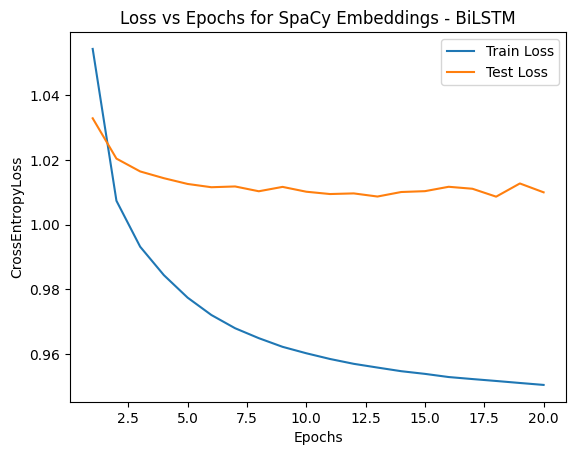

In [18]:
import matplotlib.pyplot as plt
num_epochs=20
plt.plot(range(1, num_epochs+ 1), [(x/len(training_data)) for x in train_losses], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [(x/len(testing_data)) for x in test_losses], label='Test Loss')
plt.title('Loss vs Epochs for SpaCy Embeddings - BiLSTM')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.show()

In [26]:
def post_process(predictions, label_encoding_dict):
    # Initialize an empty list to store the predicted labels
    predicted_labels = []

    # Iterate over each row in the predictions tensor
    for row in predictions:
        # Find the index of the maximum value in the row
        max_index = row.argmax().item()

        # Map the index to the corresponding label using the label_encoding_dict
        predicted_label = next(key for key, value in label_encoding_dict.items() if value == max_index)

        # Append the predicted label to the list
        predicted_labels.append(predicted_label)
    return predicted_labels


def calc_accuracy(ground_truth, predicted_labels):
  correct = 0
  for i in range(len(ground_truth)):
    if(ground_truth[i] == predicted_labels[i]):
      correct += 1
  return (correct/len(ground_truth))*100

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_metrics(model, testing_data):
  labels = ['O','B-AE','I-AE','B-Drug','I-Drug']

  y_pred=[]
  y_true=[]
  for vector_embedding, encoded_tag in testing_data:
          with torch.no_grad():
              vector_embedding=vector_embedding.to(device)
              encoded_tag=encoded_tag.to(device)
              logits = model(vector_embedding)
              y_pred.extend(logits.max(axis=1).indices.cpu().numpy())
              y_true.extend(encoded_tag.view(-1).cpu().numpy())

  total_precision = 0
  total_recall = 0
  total_f1 = 0

  # Calculate metrics for each label
  for label in range(len(labels)):
      precision = precision_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0)
      recall = recall_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0)
      f1 = f1_score(y_true, y_pred, labels=[label], average='weighted', zero_division=0)
      print(f"{labels[label]}: Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")

      total_precision += precision
      total_recall += recall
      total_f1 += f1

  avg_precision = total_precision / len(labels)
  avg_recall = total_recall / len(labels)
  avg_f1 = total_f1 / len(labels)
  # Calculate accuracy
  accuracy = accuracy_score(y_true, y_pred)
  print(f"Accuracy: {accuracy:.4f}")

  print(f"Average Precision: {avg_precision:.4f}")
  print(f"Average Recall: {avg_recall:.4f}")
  print(f"Average F1-score: {avg_f1:.4f}")

  y_true_binary = [label != 0 for label in y_true]
  y_pred_binary = [label != 0 for label in y_pred]

  auc_roc = roc_auc_score(y_true_binary, y_pred_binary)
  print(f"AUC-ROC: {auc_roc:.4f}")

In [ ]:
##non-training data is from index 5456 to 6821
idx = 6170
model.eval()
out = model(torch.tensor(vector_embeddings[idx]).to(device))
labels = post_process(out, label_encoding_dict)
print(df['Processed'][idx])
print(df['Tags'][idx])
print(labels)
print(calc_accuracy(df['Tags'][idx], labels))

['a', 'drug', 'addict', 'with', 'staphylococcal', 'endocarditis', 'treated', 'with', 'methicillin', 'who', 'developed', 'massive', 'proteinuria', 'and', 'acute', 'nephritic', 'syndrome', 'is', 'described']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'O', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
84.21052631578947


In [ ]:
low_accuracy_sentences = []
accuracy_scores = []
for idx in range(5456, len(df)):
    out = model(torch.tensor(vector_embeddings[idx]).to(device))
    labels = post_process(out, label_encoding_dict)
    acc = calc_accuracy(df['Tags'][idx], labels)
    accuracy_scores.append(acc)
    if acc < 50:
        low_accuracy_sentences.append((idx, df['Processed'][idx], df['Tags'][idx], labels, acc))

print("Overall Accuracy", sum(accuracy_scores)/len(accuracy_scores))
print("Number of sentences with accuracy less than 50%:", len(low_accuracy_sentences))

for idx, sentence, true_tags, predicted_tags, acc in low_accuracy_sentences:
    print("Index:", idx)
    print("Sentence:", sentence)
    print("True Tags:", true_tags)
    print("Predicted Tags:", predicted_tags)
    print("Accuracy:", acc)
    print()


Overall Accuracy 88.01707179278702
Number of sentences with accuracy less than 50%: 7
Index: 5732
Sentence: ['severe', 'abdominal', 'pain', 'in', 'low', 'dosage', 'clofazimine']
True Tags: ['O', 'B-AE', 'I-AE', 'O', 'O', 'O', 'B-Drug']
Predicted Tags: ['B-AE', 'I-AE', 'I-AE', 'O', 'O', 'B-Drug', 'O']
Accuracy: 42.857142857142854

Index: 5775
Sentence: ['interference', 'with', 'the', 'cortisol', 'axis', 'by', 'the', 'microtubule', 'antagonist', 'cph82']
True Tags: ['B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'I-AE', 'O', 'O', 'B-Drug']
Predicted Tags: ['B-Drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug']
Accuracy: 40.0

Index: 5828
Sentence: ['cholesterol', 'crystal', 'embolization', 'associated', 'renal', 'failure', 'after', 'therapy', 'with', 'recombinant', 'tissue', 'type', 'plasminogen', 'activator']
True Tags: ['B-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'I-Drug']
Predicted Tags: ['O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O'

In [ ]:
get_metrics(model, testing_data)

O: Precision=0.9101, Recall=0.9654, F1=0.9369
B-AE: Precision=0.6110, Recall=0.4358, F1=0.5087
I-AE: Precision=0.6276, Recall=0.3354, F1=0.4372
B-Drug: Precision=0.6903, Recall=0.7354, F1=0.7121
I-Drug: Precision=0.7479, Recall=0.2937, F1=0.4218
Accuracy: 0.8801
Average Precision: 0.7174
Average Recall: 0.5531
Average F1-score: 0.6033
AUC-ROC: 0.7473


## GRU Model

In [19]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)  # *2 for bidirectional gru

    def forward(self, x):
        gru_out, _ = self.gru(x.unsqueeze(1))
        out = self.fc(gru_out.view(len(x), -1))  # Get the last output of the sequence
        return torch.sigmoid(out).float()

In [20]:
model_gru = GRU(input_dim, hidden_dim, output_dim).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gru.parameters(), lr=0.0001)
num_epochs = 20

train_losses_gru, test_losses_gru = train_model(model_gru, loss_function, optimizer, num_epochs, training_data, testing_data)

Epoch [2/20], Train Loss: 0.9202
Epoch [2/20], Test Loss: 0.9790


Epoch [4/20], Train Loss: 0.9103
Epoch [4/20], Test Loss: 0.9566


Epoch [6/20], Train Loss: 0.9072
Epoch [6/20], Test Loss: 0.9827


Epoch [8/20], Train Loss: 0.9063
Epoch [8/20], Test Loss: 0.9601


Epoch [10/20], Train Loss: 0.9061
Epoch [10/20], Test Loss: 0.9375


Epoch [12/20], Train Loss: 0.9056
Epoch [12/20], Test Loss: 0.9505


Epoch [14/20], Train Loss: 0.9053
Epoch [14/20], Test Loss: 0.9943


Epoch [16/20], Train Loss: 0.9052
Epoch [16/20], Test Loss: 0.9801


Epoch [18/20], Train Loss: 0.9049
Epoch [18/20], Test Loss: 0.9880


Epoch [20/20], Train Loss: 0.9050
Epoch [20/20], Test Loss: 0.9909




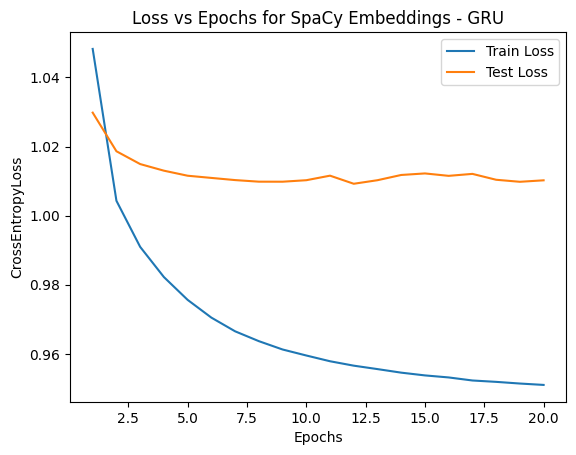

In [21]:
plt.plot(range(1, num_epochs+ 1), [(x/len(training_data)) for x in train_losses_gru], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [(x/len(testing_data)) for x in test_losses_gru], label='Test Loss')
plt.title('Loss vs Epochs for SpaCy Embeddings - GRU')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.show()

In [24]:
get_metrics(model_gru, testing_data)

O: Precision=0.9076, Recall=0.9695, F1=0.9375
B-AE: Precision=0.6469, Recall=0.4366, F1=0.5213
I-AE: Precision=0.6332, Recall=0.3364, F1=0.4394
B-Drug: Precision=0.7357, Recall=0.6953, F1=0.7149
I-Drug: Precision=0.7143, Recall=0.3135, F1=0.4358
Accuracy: 0.8823
Average Precision: 0.7275
Average Recall: 0.5503
Average F1-score: 0.6098
AUC-ROC: 0.7413


In [27]:
low_accuracy_sentences_gru = []
accuracy_scores_gru = []
for idx in range(5456, len(df)):
    out = model_gru(torch.tensor(vector_embeddings[idx]).to(device))
    labels = post_process(out, label_encoding_dict)
    acc = calc_accuracy(df['Tags'][idx], labels)
    accuracy_scores_gru.append(acc)
    if acc < 50:
        low_accuracy_sentences_gru.append((idx, df['Processed'][idx], df['Tags'][idx], labels, acc))

print("Overall Accuracy", sum(accuracy_scores_gru)/len(accuracy_scores_gru))
print("Number of sentences with accuracy less than 50%:", len(low_accuracy_sentences_gru))

for idx, sentence, true_tags, predicted_tags, acc in low_accuracy_sentences_gru:
    print("Index:", idx)
    print("Sentence:", sentence)
    print("True Tags:", true_tags)
    print("Predicted Tags:", predicted_tags)
    print("Accuracy:", acc)
    print()

Overall Accuracy 88.10923062816204
Number of sentences with accuracy less than 50%: 8
Index: 5614
Sentence: ['celiprolol', 'pneumonitis']
True Tags: ['B-Drug', 'B-AE']
Predicted Tags: ['B-AE', 'I-AE']
Accuracy: 0.0

Index: 5828
Sentence: ['cholesterol', 'crystal', 'embolization', 'associated', 'renal', 'failure', 'after', 'therapy', 'with', 'recombinant', 'tissue', 'type', 'plasminogen', 'activator']
True Tags: ['B-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'I-Drug']
Predicted Tags: ['O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Accuracy: 35.714285714285715

Index: 5960
Sentence: ['does', 'acyclovir', 'increase', 'serum', 'lithium', 'levels']
True Tags: ['O', 'B-Drug', 'B-AE', 'I-AE', 'I-AE', 'I-AE']
Predicted Tags: ['O', 'B-Drug', 'O', 'O', 'O', 'O']
Accuracy: 33.33333333333333

Index: 5967
Sentence: ['when', 'measured', 'the', 'serum', 'lithium', 'level', 'had', 'increased', '4', 'fold', 'during', 'acyclovir', '

## Glove Embeddings

In [ ]:
# Load pre-trained GloVe embeddings
def glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'rt', encoding='utf-8') as file:
        for line in file:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype=float)
            embeddings[word] = vector
    return embeddings

# Function to get embeddings for each word in a sentence
def get_embeddings(sentence, word_vectors):
    embeddings = [word_vectors[word] if word in word_vectors else np.zeros(50) for word in sentence]
    return embeddings

In [ ]:
# Replace 'glove.6B.50d.txt' with the path to your GloVe file
file_path = '/content/glove.6B.50d.txt'
embeddings_glove = glove_embeddings(file_path)

df_glove_embeddings = []
for i in range(len(df)):
  word_list = df['Processed'][i]
  sentence_embeddings = get_embeddings(word_list, embeddings_glove)
  df_glove_embeddings.append(sentence_embeddings)

In [ ]:
training_data_glove = CustomDataset(df_glove_embeddings[:5465], encoded_tags[:5465])
testing_data_glove = CustomDataset(df_glove_embeddings[5465:], encoded_tags[5465:])

### Training the Model

In [ ]:
# Initialize model, loss function, and optimizer
input_dim_glove = 50
hidden_dim = 256   # Number of units in the LSTM layer
output_dim = 5  # Output dimensionality

loss_function = nn.CrossEntropyLoss()
num_epochs = 20

model_glove = BiLSTM(input_dim_glove, hidden_dim, output_dim).to(device)
optimizer_glove = optim.Adam(model_glove.parameters(), lr=0.0001)

train_losses_glove, test_losses_glove = train_model(model_glove, loss_function, optimizer_glove, num_epochs, training_data_glove, testing_data_glove)

Epoch [2/20], Train Loss: 1.0818
Epoch [2/20], Test Loss: 0.9304


Epoch [4/20], Train Loss: 0.9941
Epoch [4/20], Test Loss: 0.9114


Epoch [6/20], Train Loss: 0.9687
Epoch [6/20], Test Loss: 0.9084


Epoch [8/20], Train Loss: 0.9515
Epoch [8/20], Test Loss: 0.9069


Epoch [10/20], Train Loss: 0.9286
Epoch [10/20], Test Loss: 0.9057


Epoch [12/20], Train Loss: 0.9158
Epoch [12/20], Test Loss: 0.9053


Epoch [14/20], Train Loss: 0.9204
Epoch [14/20], Test Loss: 0.9050


Epoch [16/20], Train Loss: 0.9093
Epoch [16/20], Test Loss: 0.9050


Epoch [18/20], Train Loss: 0.9078
Epoch [18/20], Test Loss: 0.9049


Epoch [20/20], Train Loss: 0.9059
Epoch [20/20], Test Loss: 0.9049




### Loss and Metrics

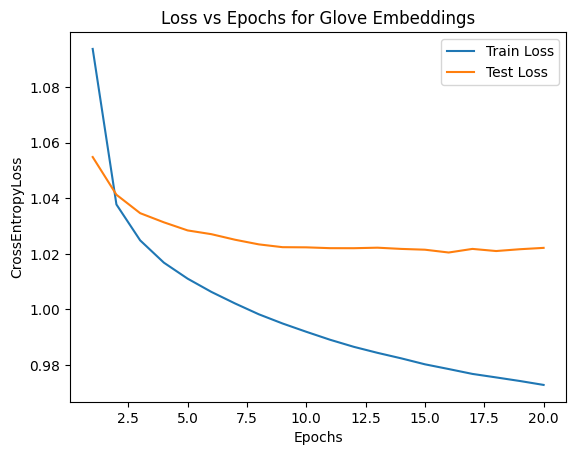

In [ ]:
import matplotlib.pyplot as plt
num_epochs=20
plt.plot(range(1, num_epochs+ 1), [(x/len(training_data_glove)) for x in train_losses_glove], label='Train Loss')
plt.plot(range(1, num_epochs + 1), [(x/len(testing_data_glove)) for x in test_losses_glove], label='Test Loss')

plt.title('Loss vs Epochs for Glove Embeddings')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend()
plt.show()

In [ ]:
low_accuracy_sentences_glove = []
accuracy_scores_glove = []
for idx in range(5456, len(df)):
    out = model_glove(torch.tensor(df_glove_embeddings[idx]).float().to(device))
    labels = post_process(out, label_encoding_dict)
    ground_truth = df.iloc[idx]['Tags']
    acc = calc_accuracy(ground_truth, labels)
    accuracy_scores_glove.append(acc)
    if acc < 50:
        low_accuracy_sentences_glove.append((idx, df['Processed'][idx], df['Tags'][idx], labels, acc))

print("Overall Accuracy", sum(accuracy_scores_glove)/len(accuracy_scores_glove))
print("Number of sentences with accuracy less than 50%:", len(low_accuracy_sentences_glove))

for idx, sentence, true_tags, predicted_tags, acc in low_accuracy_sentences_glove:
    print("Index:", idx)
    print("Sentence:", sentence)
    print("True Tags:", true_tags)
    print("Predicted Tags:", predicted_tags)
    print("Accuracy:", acc)
    print()

Overall Accuracy 87.02616239894148
Number of sentences with accuracy less than 50%: 5
Index: 5742
Sentence: ['sudden', 'death', 'in', 'an', 'infant', 'from', 'methemoglobinemia', 'after', 'administration', 'of', 'sweet', 'spirits', 'of', 'nitre']
True Tags: ['B-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'I-Drug', 'I-Drug', 'I-Drug', 'I-Drug']
Predicted Tags: ['O', 'O', 'O', 'O', 'O', 'O', 'B-Drug', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Accuracy: 42.857142857142854

Index: 6000
Sentence: ['systemic', 'corticosteroids', 'in', 'the', 'phenytoin', 'hypersensitivity', 'syndrome']
True Tags: ['O', 'O', 'O', 'O', 'B-Drug', 'I-AE', 'I-AE']
Predicted Tags: ['B-AE', 'I-AE', 'O', 'O', 'B-Drug', 'O', 'O']
Accuracy: 42.857142857142854

Index: 6323
Sentence: ['relapse', 'in', 'the', 'external', 'auditory', 'canal', 'of', 'acute', 'promyelocytic', 'leukemia', 'after', 'treatment', 'with', 'all', 'trans', 'retinoic', 'acid']
True Tags: ['B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE

In [ ]:
get_metrics(model_glove, testing_data_glove)

O: Precision=0.9028, Recall=0.9636, F1=0.9322
B-AE: Precision=0.5971, Recall=0.4181, F1=0.4919
I-AE: Precision=0.5893, Recall=0.3318, F1=0.4245
B-Drug: Precision=0.6710, Recall=0.7287, F1=0.6986
I-Drug: Precision=0.0000, Recall=0.0000, F1=0.0000
Accuracy: 0.8716
Average Precision: 0.5520
Average Recall: 0.4885
Average F1-score: 0.5095
AUC-ROC: 0.7258
